In [1]:
x=3

In [2]:
import torch

In [3]:
import pandas as pd

In [4]:
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import os
from tqdm import tqdm

In [5]:
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv, TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
# torch.manual_seed(42)

In [6]:
import mlflow.pytorch

In [7]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 1.11.0
Cuda available: True
Torch geometric version: 2.0.4


## Dataset Creation

https://github.com/quarkslab/dataset-call-graph-blogpost-material

https://colab.research.google.com/drive/17JFlnMUjcsMmXQYXF8xZ3z169VDAwUls?authuser=1

https://www.youtube.com/watch?v=QLIkOtKS4os&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=9

In [ ]:
# test_dataset = MoleculeDataset(root="data/", filename="HIV_test.csv", test=True)

In [8]:
import pickle
path_temp= "dataset-call-graph-blogpost-material/dataset/"

In [9]:
good_data=pickle.load(open(path_temp+"goodware_graphs.p","rb"))
bad_data=pickle.load(open(path_temp+"malware_graphs.p","rb"))

In [10]:
print("length of array = ",len(good_data))
print("length of 1 item = ",len(good_data[0]))
print("length of first thing in one item = ",len(good_data[0][0]))
print("length of second thing in one item = ",len(good_data[0][1]))

length of array =  546
length of 1 item =  2
length of first thing in one item =  464
length of second thing in one item =  464


In [11]:
node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

In [12]:

class MoleculeDataset(Dataset):
    def __init__(self, root, filename,good_data, bad_data, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.good_data=good_data
        self.bad_data=bad_data
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data_passed=self.good_data+self.bad_data
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return ["goodware_graphs.p","malware_graphs.p"]

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
#         self.data = self.data_passed
        return "NOt implemented yet"

        # if self.test:
        #     return [f'data_test_{i}.pt' for i in list(self.data.index)]
        # else:
        #     return [f'data_{i}.pt' for i in list(self.data.index)]

    def download(self):
        pass

    def process(self):
#         self.data = self.data_passed
        print("started doing stuff")
        index=0

        for mol in (self.good_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 1

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        for mol in (self.bad_data):
            

            feature_data=mol[0]
            neighbour_data=mol[1]

            # i need to create inst ->index
            instr_index=dict()
            for a,b in enumerate(feature_data):
              instr_index[b]=a 

            # Get node features
            node_feats = self._get_node_features(feature_data,instr_index)
            # Get edge features
            edge_feats = self._get_edge_features(neighbour_data)
#             edge_feats = []
            # Get adjacency info
            edge_index = self._get_adjacency_info(neighbour_data,instr_index)

            # Get labels info
            label = 0

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol
                        ) 
                        
            torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

            index+=1
        
        

    def process_node_features(self,val, node_feature_menu):
      # print("jj")
      # print(val)
      node_out=[]
      keys=val.keys()
      for name in node_feature_menu : 
        if(name in keys):
          node_out.append(val[name])
        else:
          node_out.append(0)
      return node_out


    def _get_node_features(self, node_features,instr_index):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        node_feature_menu=['mov', 'call', 'lea', 'jmp', 'push', 'add', 'xor', 'cmp', 'int3', 'nop', 'pushl', 'dec', 'sub', 'insl', 'inc','jz', 'jnz', 'je', 'jne', 'ja', 'jna', 'js', 'jns', 'jl', 'jnl', 'jg', 'jng']

        all_node_feats = []

        for atom in node_features:
            # print("atom is",atom)
            
            node_feats = []
            node_feats = self.process_node_features(node_features[atom],node_feature_menu)
            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        # for bond in mol.GetBonds():
        #     edge_feats = []
        #     # Feature 1: Bond type (as double)
        #     edge_feats.append(bond.GetBondTypeAsDouble())
        #     # Feature 2: Rings
        #     edge_feats.append(bond.IsInRing())
        #     # Append node features to matrix (twice, per direction)
        #     all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def get_one_instr_adjacency(self,val,instr_index,self_instruction_number):
        edge_val=[]
        for a in val:
            edge_val+=[[instr_index[self_instruction_number],instr_index[a]]]

        return edge_val

    def _get_adjacency_info(self, mol, instr_index):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol:
            edge_indices += self.get_one_instr_adjacency(mol[bond],instr_index,bond)

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
#         return self.data_pass.shape[0]
        return len(self.data_passed)

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        data = torch.load(os.path.join(self.processed_dir, 
                             f'data_{idx}.pt'))
        return data





In [13]:
train_dataset = MoleculeDataset(root="data/", filename="goodware_graphs.p", good_data=good_data, bad_data=bad_data)

Processing...


started doing stuff


Done!


In [14]:
print(train_dataset[600])

Data(x=[1222, 27], edge_index=[2, 3265], edge_attr=[0], y=0, smiles=[2])


In [15]:
print(train_dataset[1].edge_index.t())

tensor([[  1, 437],
        [  2,   4],
        [  3, 412],
        ...,
        [491, 142],
        [491, 289],
        [491, 135]])


In [16]:
print(train_dataset[1].x)

tensor([[ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [11.,  0.,  2.,  ...,  0.,  0.,  0.],
        [ 7.,  4.,  2.,  ...,  0.,  0.,  0.],
        [26., 10.,  0.,  ...,  0.,  0.,  0.]])


In [17]:
len(node_feature_menu)

27

## MODEL

In [18]:
import torch
import torch.nn.functional as F 
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.nn import TransformerConv, GATConv, TopKPooling, BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.conv.x_conv import XConv
torch.manual_seed(42)

class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        num_classes = 2
        embedding_size = 27

        # GNN layers
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)

        # Linear layers
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024, num_classes)  

    def forward(self, x, edge_attr, edge_index, batch_index):
        # First block
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)

        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Second block
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Third block
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x, 
                                                        edge_index, 
                                                        None, 
                                                        batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # Concat pooled vectors
        x = x1 + x2 + x3

        # Output block
        x = self.linear1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)

        return x


In [19]:
import torch 
from torch_geometric.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
# from dataset_featurizer import MoleculeDataset
# from model import GNN
import mlflow.pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)





In [20]:

# BEST_PARAMETERS = {
#     "batch_size": [128],
#     "learning_rate": [0.01],
#     "weight_decay": [0.0001],
#     "sgd_momentum": [0.8],
#     "scheduler_gamma": [0.8],
#     "pos_weight": [1.3],
#     "model_embedding_size": [64],
#     "model_attention_heads": [3],
#     "model_layers": [4],
#     "model_dropout_rate": [0.2],
#     "model_top_k_ratio": [0.5],
#     "model_top_k_every_n": [1],
#     "model_dense_neurons": [256]
# }

In [21]:
# #%% Loss and Optimizer
# # new one 

# # weights = torch.tensor([1, 20], dtype=torch.float32).to(device)
# # loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

# weight2 = torch.tensor([BEST_PARAMETERS["pos_weight"]], dtype=torch.float32).to(device)
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight2)

# optimizer = torch.optim.SGD(model.parameters(), lr=BEST_PARAMETERS['learning_rate'], momentum=BEST_PARAMETERS['sgd_momentum'], weight_decay=BEST_PARAMETERS["weight_decay"])  
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=BEST_PARAMETERS["scheduler_gamma"])


In [23]:
#%% Loading the model
model = GNN(feature_size=train_dataset[0].x.shape[1]) 
model = model.to(device)
print(f"Number of parameters: {count_parameters(model)}")
model

Number of parameters: 72383


GNN(
  (conv1): GATConv(27, 27, heads=3)
  (head_transform1): Linear(in_features=81, out_features=27, bias=True)
  (pool1): TopKPooling(27, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(27, 27, heads=3)
  (head_transform2): Linear(in_features=81, out_features=27, bias=True)
  (pool2): TopKPooling(27, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(27, 27, heads=3)
  (head_transform3): Linear(in_features=81, out_features=27, bias=True)
  (pool3): TopKPooling(27, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=54, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [24]:
#%% Loss and Optimizer
# original
weights = torch.tensor([1, 3], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)  
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


In [25]:
optimizer.zero_grad()        
# loss, hidden = model(data, hidden, targets)
# loss.backward()
clip_value=10
torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
optimizer.step()

In [27]:
weights

tensor([1., 3.], device='cuda:0')

In [30]:
len(train_dataset[:1261])

1261

In [33]:
train_dataset[1].y

1

In [36]:
br=0
for a,b in enumerate(train_dataset):
    if (b.y==0):
        br=a
        break
print(br)

546


In [37]:
test_cut_dataset=train_dataset[526:566]
train_cut_dataset= train_dataset[:526]+train_dataset[566:]

In [39]:
#%% Prepare training
NUM_GRAPHS_PER_BATCH = 256
# NUM_GRAPHS_PER_BATCH = 1

train_loader = DataLoader(train_cut_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True,
                         num_workers=0)
# test_loader = DataLoader(test_dataset, 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_cut_dataset, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


D:\Anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [40]:
def test(epoch):
    all_preds = []
    all_labels = []
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = torch.sqrt(loss_fn(pred, batch.y))    
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    return loss


def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_pred, y_true)}")
    print(f"Accuracy: {accuracy_score(y_pred, y_true)}")
    print(f"Precision: {precision_score(y_pred, y_true)}")
    print(f"Recall: {recall_score(y_pred, y_true)}")
    try:
        roc = roc_auc_score(y_pred, y_true)
        print(f"ROC AUC: {roc}")
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(roc), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"ROC AUC: notdefined")
        
    try:
        mlflow.log_metric(key=f"accuracy-{type}", value=float(accuracy_score(y_pred, y_true)), step=epoch)
    except:
        mlflow.log_metric(key=f"ROC-AUC-{type}", value=float(0), step=epoch)
        print(f"Accuracy: notdefined")

In [41]:

def train(epoch):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        # Use GPU
        batch.to(device)  
        # Reset gradients

        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model(batch.x.float(), 
                                batch.edge_attr.float(),
                                batch.edge_index, 
                                batch.batch) 
        # Calculating the loss and gradients
#         loss = torch.sqrt(loss_fn(pred, batch.y)) 
        loss_v1 = loss_fn(pred, batch.y) 
        loss_v2=torch.sqrt(loss_v1)
#         print("batch.y")
#         print(batch.y)
        
#         print("pred")
#         print(pred)
        
#         print("loss_v1")
#         print(loss_v1)
#         print("loss_v2")
#         print(loss_v2)
        
        loss=loss_v2
        loss.backward()  
        # Update using the gradients
        optimizer.step()  

        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return loss




In [42]:

# %% Run the training
with mlflow.start_run() as run:
    for epoch in range(50):
        # Training
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)

        # Testing
        model.eval()
        if epoch % 5 == 0:
            loss = test(epoch=epoch)
            loss = loss.detach().cpu().numpy()
            print(f"Epoch {epoch} | Test Loss {loss}")
            mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)

        scheduler.step()
print("Done.")



100%|██████████| 6/6 [02:10<00:00, 21.74s/it]



 Confusion matrix: 
 [[118  78]
 [677 448]]
F1 Score: 0.5427013930950938
Accuracy: 0.4284632853898562
Precision: 0.8517110266159695
Recall: 0.3982222222222222
ROC AUC: 0.5001315192743765
Epoch 0 | Train Loss 7.14923095703125

 Confusion matrix: 
 [[ 0  0]
 [20 20]]
F1 Score: 0.6666666666666666
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
ROC AUC: notdefined
Epoch 0 | Test Loss 3.0103163719177246


100%|██████████| 6/6 [00:45<00:00,  7.60s/it]



 Confusion matrix: 
 [[ 30  20]
 [765 506]]
F1 Score: 0.5631608235948804
Accuracy: 0.4057532172596518
Precision: 0.9619771863117871
Recall: 0.3981117230527144
ROC AUC: 0.4990558615263572
Epoch 1 | Train Loss 3.3494887351989746


100%|██████████| 6/6 [00:21<00:00,  3.58s/it]



 Confusion matrix: 
 [[333 190]
 [462 336]]
F1 Score: 0.5075528700906344
Accuracy: 0.5064345193035579
Precision: 0.6387832699619772
Recall: 0.42105263157894735
ROC AUC: 0.5288819563248466
Epoch 2 | Train Loss 1.4967868328094482


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]



 Confusion matrix: 
 [[453 246]
 [342 280]]
F1 Score: 0.4878048780487804
Accuracy: 0.554882664647994
Precision: 0.532319391634981
Recall: 0.45016077170418006
ROC AUC: 0.5491147206160385
Epoch 3 | Train Loss 1.9268443584442139


100%|██████████| 6/6 [00:22<00:00,  3.71s/it]



 Confusion matrix: 
 [[334 132]
 [461 394]]
F1 Score: 0.5706010137581462
Accuracy: 0.5510976532929599
Precision: 0.7490494296577946
Recall: 0.4608187134502924
ROC AUC: 0.5887784554375926
Epoch 4 | Train Loss 1.6136562824249268


100%|██████████| 6/6 [00:22<00:00,  3.67s/it]



 Confusion matrix: 
 [[416 147]
 [379 379]]
F1 Score: 0.5903426791277259
Accuracy: 0.6018168054504164
Precision: 0.720532319391635
Recall: 0.5
ROC AUC: 0.6194493783303731
Epoch 5 | Train Loss 1.458888053894043

 Confusion matrix: 
 [[ 9  1]
 [11 19]]
F1 Score: 0.7599999999999999
Accuracy: 0.7
Precision: 0.95
Recall: 0.6333333333333333
ROC AUC: 0.7666666666666666
Epoch 5 | Test Loss 0.9088563323020935


100%|██████████| 6/6 [00:21<00:00,  3.66s/it]



 Confusion matrix: 
 [[432 115]
 [363 411]]
F1 Score: 0.6323076923076923
Accuracy: 0.6381529144587433
Precision: 0.7813688212927756
Recall: 0.5310077519379846
ROC AUC: 0.6603850459872738
Epoch 6 | Train Loss 1.7031556367874146


100%|██████████| 6/6 [00:22<00:00,  3.67s/it]



 Confusion matrix: 
 [[397 127]
 [398 399]]
F1 Score: 0.6031746031746031
Accuracy: 0.6025738077214232
Precision: 0.7585551330798479
Recall: 0.5006273525721455
ROC AUC: 0.6291304701792024
Epoch 7 | Train Loss 1.2515614032745361


100%|██████████| 6/6 [00:21<00:00,  3.59s/it]



 Confusion matrix: 
 [[399 134]
 [396 392]]
F1 Score: 0.5966514459665144
Accuracy: 0.5987887963663892
Precision: 0.7452471482889734
Recall: 0.49746192893401014
ROC AUC: 0.6230273997390501
Epoch 8 | Train Loss 1.1769248247146606


100%|██████████| 6/6 [00:21<00:00,  3.56s/it]



 Confusion matrix: 
 [[422 126]
 [373 400]]
F1 Score: 0.6158583525789068
Accuracy: 0.6222558667676003
Precision: 0.7604562737642585
Recall: 0.517464424320828
ROC AUC: 0.6437687085107789
Epoch 9 | Train Loss 0.8918960094451904


100%|██████████| 6/6 [00:21<00:00,  3.55s/it]



 Confusion matrix: 
 [[414 110]
 [381 416]]
F1 Score: 0.6288737717309146
Accuracy: 0.6283118849356548
Precision: 0.7908745247148289
Recall: 0.5219573400250941
ROC AUC: 0.6560168379514784
Epoch 10 | Train Loss 0.9208008050918579

 Confusion matrix: 
 [[ 9  0]
 [11 20]]
F1 Score: 0.7843137254901961
Accuracy: 0.725
Precision: 1.0
Recall: 0.6451612903225806
ROC AUC: 0.8225806451612903
Epoch 10 | Test Loss 0.6514346599578857


100%|██████████| 6/6 [00:21<00:00,  3.58s/it]



 Confusion matrix: 
 [[392 101]
 [403 425]]
F1 Score: 0.6277695716395864
Accuracy: 0.6184708554125662
Precision: 0.8079847908745247
Recall: 0.5132850241545893
ROC AUC: 0.6542084349981871
Epoch 11 | Train Loss 0.675172746181488


100%|██████████| 6/6 [00:21<00:00,  3.60s/it]



 Confusion matrix: 
 [[459 107]
 [336 419]]
F1 Score: 0.6541764246682279
Accuracy: 0.6646479939439819
Precision: 0.7965779467680608
Recall: 0.5549668874172186
ROC AUC: 0.6829604755107295
Epoch 12 | Train Loss 0.7522151470184326


100%|██████████| 6/6 [00:21<00:00,  3.54s/it]



 Confusion matrix: 
 [[403  77]
 [392 449]]
F1 Score: 0.6569129480614485
Accuracy: 0.6449659348978047
Precision: 0.8536121673003803
Recall: 0.5338882282996433
ROC AUC: 0.6867357808164885
Epoch 13 | Train Loss 0.7266365885734558


100%|██████████| 6/6 [00:21<00:00,  3.54s/it]



 Confusion matrix: 
 [[409  95]
 [386 431]]
F1 Score: 0.6418466120625466
Accuracy: 0.6358819076457229
Precision: 0.8193916349809885
Recall: 0.5275397796817626
ROC AUC: 0.6695238580948496
Epoch 14 | Train Loss 0.8386929631233215


100%|██████████| 6/6 [00:21<00:00,  3.54s/it]



 Confusion matrix: 
 [[398  91]
 [397 435]]
F1 Score: 0.6406480117820325
Accuracy: 0.6305828917486752
Precision: 0.8269961977186312
Recall: 0.5228365384615384
ROC AUC: 0.668371234465943
Epoch 15 | Train Loss 0.7091758847236633

 Confusion matrix: 
 [[ 9  2]
 [11 18]]
F1 Score: 0.7346938775510204
Accuracy: 0.675
Precision: 0.9
Recall: 0.6206896551724138
ROC AUC: 0.7194357366771159
Epoch 15 | Test Loss 0.641054093837738


100%|██████████| 6/6 [00:21<00:00,  3.63s/it]



 Confusion matrix: 
 [[406  78]
 [389 448]]
F1 Score: 0.6573734409391049
Accuracy: 0.6464799394398183
Precision: 0.8517110266159695
Recall: 0.5352449223416965
ROC AUC: 0.687043948774154
Epoch 16 | Train Loss 0.7794815301895142


100%|██████████| 6/6 [00:23<00:00,  3.86s/it]



 Confusion matrix: 
 [[402  86]
 [393 440]]
F1 Score: 0.6475349521707137
Accuracy: 0.6373959121877366
Precision: 0.8365019011406845
Recall: 0.5282112845138055
ROC AUC: 0.6759908881585421
Epoch 17 | Train Loss 0.791157066822052


100%|██████████| 6/6 [00:21<00:00,  3.66s/it]



 Confusion matrix: 
 [[426 104]
 [369 422]]
F1 Score: 0.6408504176157935
Accuracy: 0.6419379258137774
Precision: 0.8022813688212928
Recall: 0.5335018963337548
ROC AUC: 0.6686377406197076
Epoch 18 | Train Loss 0.8376214504241943


100%|██████████| 6/6 [00:50<00:00,  8.45s/it]



 Confusion matrix: 
 [[434 100]
 [361 426]]
F1 Score: 0.6488956587966489
Accuracy: 0.6510219530658592
Precision: 0.8098859315589354
Recall: 0.5412960609911055
ROC AUC: 0.6770150716940546
Epoch 19 | Train Loss 0.9767336845397949


100%|██████████| 6/6 [00:35<00:00,  5.87s/it]



 Confusion matrix: 
 [[436  99]
 [359 427]]
F1 Score: 0.6509146341463414
Accuracy: 0.6532929598788796
Precision: 0.811787072243346
Recall: 0.5432569974554707
ROC AUC: 0.679105134241754
Epoch 20 | Train Loss 0.6654081344604492

 Confusion matrix: 
 [[11  2]
 [ 9 18]]
F1 Score: 0.7659574468085106
Accuracy: 0.725
Precision: 0.9
Recall: 0.6666666666666666
ROC AUC: 0.7564102564102564
Epoch 20 | Test Loss 0.6466525197029114


100%|██████████| 6/6 [00:41<00:00,  6.98s/it]



 Confusion matrix: 
 [[435  87]
 [360 439]]
F1 Score: 0.6626415094339623
Accuracy: 0.6616199848599545
Precision: 0.8346007604562737
Recall: 0.5494367959949937
ROC AUC: 0.6913850646641635
Epoch 21 | Train Loss 0.9061850905418396


100%|██████████| 6/6 [00:38<00:00,  6.42s/it]



 Confusion matrix: 
 [[423  95]
 [372 431]]
F1 Score: 0.6486079759217457
Accuracy: 0.6464799394398183
Precision: 0.8193916349809885
Recall: 0.5367372353673724
ROC AUC: 0.6766697759848445
Epoch 22 | Train Loss 0.8667916655540466


100%|██████████| 6/6 [00:24<00:00,  4.14s/it]



 Confusion matrix: 
 [[411  76]
 [384 450]]
F1 Score: 0.6617647058823529
Accuracy: 0.651778955336866
Precision: 0.8555133079847909
Recall: 0.539568345323741
ROC AUC: 0.6917554252286056
Epoch 23 | Train Loss 0.952942967414856


100%|██████████| 6/6 [00:26<00:00,  4.48s/it]



 Confusion matrix: 
 [[403  78]
 [392 448]]
F1 Score: 0.6559297218155197
Accuracy: 0.6442089326267979
Precision: 0.8517110266159695
Recall: 0.5333333333333333
ROC AUC: 0.6855855855855856
Epoch 24 | Train Loss 0.8527230620384216


100%|██████████| 6/6 [00:24<00:00,  4.15s/it]



 Confusion matrix: 
 [[420  73]
 [375 453]]
F1 Score: 0.6691285081240769
Accuracy: 0.6608629825889477
Precision: 0.8612167300380228
Recall: 0.5471014492753623
ROC AUC: 0.6995142134814946
Epoch 25 | Train Loss 0.7687628269195557

 Confusion matrix: 
 [[ 9  2]
 [11 18]]
F1 Score: 0.7346938775510204
Accuracy: 0.675
Precision: 0.9
Recall: 0.6206896551724138
ROC AUC: 0.7194357366771159
Epoch 25 | Test Loss 0.6435644626617432


100%|██████████| 6/6 [00:24<00:00,  4.11s/it]



 Confusion matrix: 
 [[426  88]
 [369 438]]
F1 Score: 0.6571642910727681
Accuracy: 0.6540499621498864
Precision: 0.8326996197718631
Recall: 0.5427509293680297
ROC AUC: 0.6857723518435479
Epoch 26 | Train Loss 0.7637110948562622


100%|██████████| 6/6 [00:24<00:00,  4.16s/it]



 Confusion matrix: 
 [[434  80]
 [361 446]]
F1 Score: 0.6691672918229556
Accuracy: 0.6661619984859954
Precision: 0.8479087452471483
Recall: 0.5526641883519207
ROC AUC: 0.6985110825028086
Epoch 27 | Train Loss 0.8082166314125061


100%|██████████| 6/6 [00:24<00:00,  4.07s/it]



 Confusion matrix: 
 [[397  89]
 [398 437]]
F1 Score: 0.642174871418075
Accuracy: 0.631339894019682
Precision: 0.8307984790874525
Recall: 0.5233532934131736
ROC AUC: 0.6701128606983563
Epoch 28 | Train Loss 0.7720353603363037


100%|██████████| 6/6 [00:37<00:00,  6.28s/it]



 Confusion matrix: 
 [[404  75]
 [391 451]]
F1 Score: 0.6593567251461987
Accuracy: 0.6472369417108251
Precision: 0.8574144486692015
Recall: 0.5356294536817102
ROC AUC: 0.6895266266320869
Epoch 29 | Train Loss 0.8058992624282837


100%|██████████| 6/6 [00:21<00:00,  3.67s/it]



 Confusion matrix: 
 [[419  84]
 [376 442]]
F1 Score: 0.6577380952380952
Accuracy: 0.651778955336866
Precision: 0.8403041825095057
Recall: 0.5403422982885085
ROC AUC: 0.6866721431800396
Epoch 30 | Train Loss 0.7651630640029907

 Confusion matrix: 
 [[ 9  2]
 [11 18]]
F1 Score: 0.7346938775510204
Accuracy: 0.675
Precision: 0.9
Recall: 0.6206896551724138
ROC AUC: 0.7194357366771159
Epoch 30 | Test Loss 0.6471891403198242


100%|██████████| 6/6 [00:22<00:00,  3.74s/it]



 Confusion matrix: 
 [[446  80]
 [349 446]]
F1 Score: 0.6752460257380772
Accuracy: 0.6752460257380772
Precision: 0.8479087452471483
Recall: 0.5610062893081761
ROC AUC: 0.7044575172776621
Epoch 31 | Train Loss 0.7165416479110718


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]



 Confusion matrix: 
 [[430  82]
 [365 444]]
F1 Score: 0.6651685393258427
Accuracy: 0.6616199848599545
Precision: 0.844106463878327
Recall: 0.5488257107540173
ROC AUC: 0.6943347303770087
Epoch 32 | Train Loss 0.7081127762794495


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]



 Confusion matrix: 
 [[409  86]
 [386 440]]
F1 Score: 0.650887573964497
Accuracy: 0.6426949280847842
Precision: 0.8365019011406845
Recall: 0.5326876513317191
ROC AUC: 0.6794751387971727
Epoch 33 | Train Loss 0.7749207615852356


100%|██████████| 6/6 [00:22<00:00,  3.70s/it]



 Confusion matrix: 
 [[424  90]
 [371 436]]
F1 Score: 0.6541635408852213
Accuracy: 0.6510219530658592
Precision: 0.8288973384030418
Recall: 0.540272614622057
ROC AUC: 0.6825876691787328
Epoch 34 | Train Loss 0.8163408637046814


100%|██████████| 6/6 [00:22<00:00,  3.70s/it]



 Confusion matrix: 
 [[424  83]
 [371 443]]
F1 Score: 0.6611940298507464
Accuracy: 0.6563209689629069
Precision: 0.8422053231939164
Recall: 0.5442260442260443
ROC AUC: 0.6902589787205172
Epoch 35 | Train Loss 0.6926417350769043

 Confusion matrix: 
 [[ 9  2]
 [11 18]]
F1 Score: 0.7346938775510204
Accuracy: 0.675
Precision: 0.9
Recall: 0.6206896551724138
ROC AUC: 0.7194357366771159
Epoch 35 | Test Loss 0.6473941802978516


100%|██████████| 6/6 [00:22<00:00,  3.68s/it]



 Confusion matrix: 
 [[436  91]
 [359 435]]
F1 Score: 0.6590909090909091
Accuracy: 0.6593489780469342
Precision: 0.8269961977186312
Recall: 0.5478589420654912
ROC AUC: 0.6875917101219297
Epoch 36 | Train Loss 0.746647298336029


100%|██████████| 6/6 [00:21<00:00,  3.63s/it]



 Confusion matrix: 
 [[427  92]
 [368 434]]
F1 Score: 0.6536144578313253
Accuracy: 0.651778955336866
Precision: 0.8250950570342205
Recall: 0.5411471321695761
ROC AUC: 0.6819415814990463
Epoch 37 | Train Loss 0.762109637260437


100%|██████████| 6/6 [00:22<00:00,  3.71s/it]



 Confusion matrix: 
 [[409  80]
 [386 446]]
F1 Score: 0.6568483063328424
Accuracy: 0.6472369417108251
Precision: 0.8479087452471483
Recall: 0.5360576923076923
ROC AUC: 0.6862292551518012
Epoch 38 | Train Loss 0.8660204410552979


100%|██████████| 6/6 [00:21<00:00,  3.64s/it]



 Confusion matrix: 
 [[441  91]
 [354 435]]
F1 Score: 0.6615969581749049
Accuracy: 0.6631339894019682
Precision: 0.8269961977186312
Recall: 0.5513307984790875
ROC AUC: 0.69013908345007
Epoch 39 | Train Loss 0.9353006482124329


100%|██████████| 6/6 [00:22<00:00,  3.79s/it]



 Confusion matrix: 
 [[432  87]
 [363 439]]
F1 Score: 0.661144578313253
Accuracy: 0.6593489780469342
Precision: 0.8346007604562737
Recall: 0.5473815461346634
ROC AUC: 0.6898757441655976
Epoch 40 | Train Loss 0.9039078950881958

 Confusion matrix: 
 [[ 9  2]
 [11 18]]
F1 Score: 0.7346938775510204
Accuracy: 0.675
Precision: 0.9
Recall: 0.6206896551724138
ROC AUC: 0.7194357366771159
Epoch 40 | Test Loss 0.6470843553543091


100%|██████████| 6/6 [00:22<00:00,  3.70s/it]



 Confusion matrix: 
 [[433  84]
 [362 442]]
F1 Score: 0.6646616541353384
Accuracy: 0.6623769871309614
Precision: 0.8403041825095057
Recall: 0.5497512437810945
ROC AUC: 0.6936377108654023
Epoch 41 | Train Loss 0.6104321479797363


100%|██████████| 6/6 [00:22<00:00,  3.74s/it]



 Confusion matrix: 
 [[428  76]
 [367 450]]
F1 Score: 0.6701414743112435
Accuracy: 0.6646479939439819
Precision: 0.8555133079847909
Recall: 0.5507955936352509
ROC AUC: 0.7000009714208
Epoch 42 | Train Loss 0.8458795547485352


100%|██████████| 6/6 [00:21<00:00,  3.62s/it]



 Confusion matrix: 
 [[435  99]
 [360 427]]
F1 Score: 0.6504188880426504
Accuracy: 0.6525359576078729
Precision: 0.811787072243346
Recall: 0.542566709021601
ROC AUC: 0.6785867252973173
Epoch 43 | Train Loss 1.4746516942977905


100%|██████████| 6/6 [00:21<00:00,  3.65s/it]



 Confusion matrix: 
 [[423  85]
 [372 441]]
F1 Score: 0.6587005227781928
Accuracy: 0.6540499621498864
Precision: 0.8384030418250951
Recall: 0.5424354243542435
ROC AUC: 0.687556294854287
Epoch 44 | Train Loss 0.7814270853996277


100%|██████████| 6/6 [00:22<00:00,  3.73s/it]



 Confusion matrix: 
 [[423  80]
 [372 446]]
F1 Score: 0.6636904761904763
Accuracy: 0.6578349735049205
Precision: 0.8479087452471483
Recall: 0.5452322738386308
ROC AUC: 0.6930932740962538
Epoch 45 | Train Loss 0.8216545581817627

 Confusion matrix: 
 [[ 9  2]
 [11 18]]
F1 Score: 0.7346938775510204
Accuracy: 0.675
Precision: 0.9
Recall: 0.6206896551724138
ROC AUC: 0.7194357366771159
Epoch 45 | Test Loss 0.6470317244529724


100%|██████████| 6/6 [00:22<00:00,  3.76s/it]



 Confusion matrix: 
 [[436  89]
 [359 437]]
F1 Score: 0.6611195158850227
Accuracy: 0.6608629825889477
Precision: 0.8307984790874525
Recall: 0.5489949748743719
ROC AUC: 0.6897355826752812
Epoch 46 | Train Loss 0.8215861916542053


100%|██████████| 6/6 [00:21<00:00,  3.66s/it]



 Confusion matrix: 
 [[432  94]
 [363 432]]
F1 Score: 0.6540499621498864
Accuracy: 0.6540499621498864
Precision: 0.8212927756653993
Recall: 0.5433962264150943
ROC AUC: 0.6823445010402468
Epoch 47 | Train Loss 0.956259548664093


100%|██████████| 6/6 [00:22<00:00,  3.73s/it]



 Confusion matrix: 
 [[433  81]
 [362 445]]
F1 Score: 0.6676669167291823
Accuracy: 0.6646479939439819
Precision: 0.8460076045627376
Recall: 0.5514250309789344
ROC AUC: 0.6969187411704011
Epoch 48 | Train Loss 0.8883705139160156


100%|██████████| 6/6 [00:21<00:00,  3.61s/it]



 Confusion matrix: 
 [[427  81]
 [368 445]]
F1 Score: 0.6646751306945481
Accuracy: 0.660105980317941
Precision: 0.8460076045627376
Recall: 0.5473554735547356
ROC AUC: 0.6939533273285489
Epoch 49 | Train Loss 0.6841525435447693
Done.


In [55]:

# %% Save the model 
mlflow.pytorch.log_model(model, "model") 

2022/04/23 15:31:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\JERRYJ~1\AppData\Local\Temp\tmp5sdh5yz_\model\data, flavor: pytorch), fall back to return ['torch==1.11.0', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.
D:\Anaconda3\envs\pytorch\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


ModelInfo(artifact_path='model', flavors={'pytorch': {'model_data': 'data', 'pytorch_version': '1.11.0', 'code': None}, 'python_function': {'pickle_module_name': 'mlflow.pytorch.pickle_module', 'loader_module': 'mlflow.pytorch', 'python_version': '3.9.12', 'data': 'data', 'env': 'conda.yaml'}}, model_uri='runs:/cc21dc71c0534040841e16dbca0e94bc/model', model_uuid='0b947a31a40446c39570297bbf4897d7', run_id='cc21dc71c0534040841e16dbca0e94bc', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-04-23 10:00:57.036793', mlflow_version='1.25.1')

Confusion Matrix

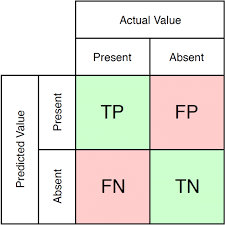

In [43]:
model_type_name="findr_gcn_model1"

In [49]:
from datetime import date
from datetime import datetime


In [67]:
# SAVE MODEL
#  pls create a folder named model_saved if not there
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y %H_%M_%S")
PATH_to_save_model="model_saved/"+"model_"+dt_string+":"+model_type_name+".pt"
PATH_to_save_model="model_saved/model "+dt_string+".pt"
torch.save(model, PATH_to_save_model)

In [68]:
# Model class must be defined somewhere
model2 = torch.load(PATH_to_save_model)
model2.eval()

GNN(
  (conv1): GATConv(27, 27, heads=3)
  (head_transform1): Linear(in_features=81, out_features=27, bias=True)
  (pool1): TopKPooling(27, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(27, 27, heads=3)
  (head_transform2): Linear(in_features=81, out_features=27, bias=True)
  (pool2): TopKPooling(27, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(27, 27, heads=3)
  (head_transform3): Linear(in_features=81, out_features=27, bias=True)
  (pool3): TopKPooling(27, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=54, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)